# 0. Daten importieren

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Laden der Daten
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')

# Kombinieren der Trainingswerte und -labels
train_data = train_values.merge(train_labels, on='building_id')

# 1. Betrachte "wichtige" Spalten

- `x`: Wir entfernen  die Spalten `building_id` und `damage_grade` aus dem Datensatz und weisen den Rest der Spalten, die die Features darstellen, der Variablen X zu. 

- `y`: Wir weisen die Spalte `damage_grade` (Zielvariable) der Variablen y zu.

In [27]:
# Teilen der Daten in Features und Labels
X = train_data.drop(columns=['building_id', 'damage_grade'])
y = train_data['damage_grade']

# 2. Vorverarbeitung der Daten:

- Wir wollen keinen Verstoß gegen unterschliedlichen Datentypen haben.
- One-Hot-Encoding: Umwandlung von kategorialen Daten in numerische Eingaben für unser Modell
- Wir verwandeln die kategorialen Merkmale in eine (numerische) Form, die von unserem Modell verarbeitet werden kann, indem wir für jede Kategorie in den Daten eine eigene Spalte erstellt.
- Für jede Beobachtung wird dann eine "1" in die Spalte der Kategorie gesetzt, zu der sie gehört, und eine "0" in alle anderen Kategoriespalten.
- Wir entfernen die kategorialen Spalten und fügen die entsprechenden one-hot-kodierten Spalten hinzu.

In [ ]:
# One-Hot-Encoding für kategoriale Variablen
categorical_cols = X.select_dtypes(include=['object']).columns
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(X[categorical_cols])

# Methode, um die (eindeutigen) Namen der erzeugten Features zu erhalten
encoded_cols = []
for i, col in enumerate(categorical_cols):
    encoded_cols += [f'{col}_{category}' for category in one_hot_encoder.categories_[i]]

X_encoded = pd.DataFrame(one_hot_encoded, columns=encoded_cols)
X = pd.concat([X.drop(columns=categorical_cols), X_encoded], axis=1)

# 3. RandomForest - Modelltraining
- Wir trainieren jetzt ein Random-Forest-Klassifikationsmodell.
- Wir teilen Datensatz zufällig auf: 80% der Daten werden zum Trainieren des Modells verwendet und die restlichen 20% werden verwendet, um die Genauigkeit des Modells zu testen. 
- Anschließend wird das Modell erstellt. In diesem Fall ist es ein Random Forest Classifier. Dieser macht Vorhersage.
- Bewertung der Leistung des Modells: Es vergleicht die Vorhersagen des Modells (y_pred) mit den tatsächlichen Werten (y_test) und gibt uns eine Tabelle, der verschiedene Statistiken enthält, die die Leistung des Modells zusammenfassen, darunter die Präzision, die Sensitivität und der F1-Score. Ergebnis von F1: 0,71 (siehe unten)

In [29]:
# Aufteilen der Daten in einen Trainings- und einen Testdatensatz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Erstellen und Trainieren des Modells
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

# Bewertung des Modells
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.47      0.55      5170
           2       0.72      0.82      0.77     29487
           3       0.71      0.59      0.65     17464

    accuracy                           0.71     52121
   macro avg       0.70      0.63      0.66     52121
weighted avg       0.71      0.71      0.71     52121



# 4. Ergebnis interpretieren (F1-Score)

- `precision`: Dies ist der Anteil der positiven Vorhersagen, die korrekt waren. Ein hoher Präzisionswert bedeutet, dass das Modell, wenn es eine bestimmte Klasse vorhersagt, in der Regel richtig liegt.

- `recall`: Dies ist der Anteil der tatsächlichen positiven Fälle, die das Modell korrekt identifiziert hat. Ein hoher Wiedererkennungswert bedeutet, dass das Modell die meisten tatsächlichen Fälle einer bestimmten Klasse identifiziert.

- `f1-score`: Dies ist das harmonische Mittel aus Präzision und Recall. Der F1-Score versucht, einen Kompromiss zwischen Präzision und Recall zu finden und kann eine nützliche Metrik sein, wenn die Kosten für falsche Positive und falsche Negative unterschiedlich sind.

- `support`: Dies ist die Anzahl der tatsächlichen Fälle jeder Klasse in unserem Testdatensatz.

Die letzten drei Zeilen (`accuracy`, `macro avg`, `weighted avg`) zeigen Durchschnittswerte für alle Klassen. Genauigkeit ist der Anteil aller korrekten Vorhersagen. Die `macro avg` berechnet das arithmetische Mittel der Metriken für jede Klasse. Die `weighted avg` berechnet den Durchschnitt, wobei jede Klasse proportional zu ihrer Größe in den Daten gewichtet wird.

Ein F1-Score von 0,71 auf einer Skala von 0 bis 1 für eine mehrklassige Klassifikationsaufgabe ist ziemlich gut. Es zeigt an, dass das Modell in der Lage ist, die Klassen ziemlich genau vorherzusagen. Aber es gibt immer Raum für Verbesserungen. Man könnte versuchen, andere Modelle oder Feature Engineering-Techniken zu verwenden, um die Leistung zu verbessern.

## 4.1 Visualisierung der Ergebnisse
- Histogramm (Verteilung der Vorhersagen)
- Konfusionsmatrix (Korrektheit der Aussage)
- Wichtigkeit der Merkmale
- Lernkurve (Änderung der F1-Score im Laufe der Zeit)

### 4.1.1 Histogramm (Verteilung der Vorhersagen)
Da wir mit einer Klassifikation mit mehreren Klassen arbeiten und wir Vorhersagen für diese Klassen gemacht haben, wäre es sinnvoll, die Verteilung dieser Vorhersagen zu visualisieren. Eine Möglichkeit, dies zu tun, wäre die Verwendung eines Histogramms.

Hier sehen wir ein Histogramm, das zeigt, wie viele Gebäude das Modell in jede Schadensklasse eingeteilt hat. Man kann leicht verstehen, wie das Modell seine Vorhersagen verteilt hat.

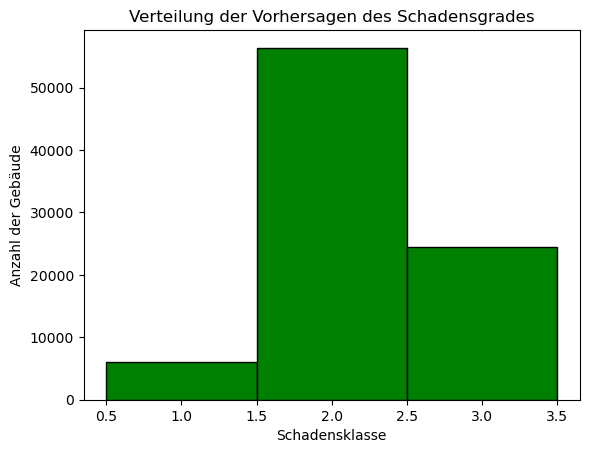

In [30]:
import matplotlib.pyplot as plt

# Erzeugen eines Histogramms der Vorhersagen
plt.hist(test_predictions, bins=[1, 2, 3, 4], align='left', color='green', edgecolor='black')

plt.xlabel('Schadensklasse')
plt.ylabel('Anzahl der Gebäude')
plt.title('Verteilung der Vorhersagen des Schadensgrades')

plt.show()

### 4.1.2 Konfusionsmatrix (Korrektheit der Aussage)
Die unten stehende Konfusionsmatrix zeigt die Anzahl der korrekten und falschen Vorhersagen für jede Klasse. Die Hauptdiagonale der Matrix zeigt die Anzahl der korrekten Vorhersagen.

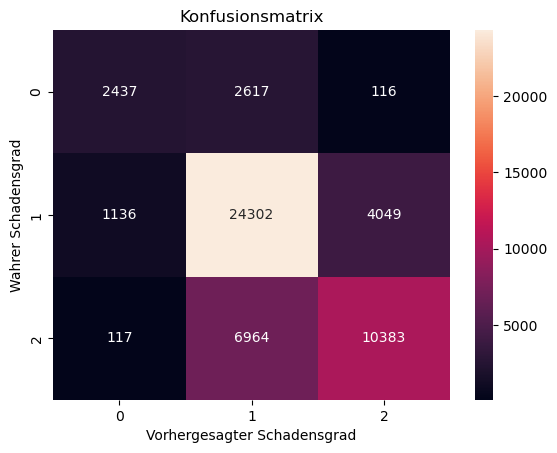

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagter Schadensgrad')
plt.ylabel('Wahrer Schadensgrad')
plt.show()

### 4.1.3 Wichtigkeit der Merkmale
Diese Grafik hilft uns, zu verstehen, welche Merkmale das Modell für seine Vorhersagen als am wichtigsten erachtet.

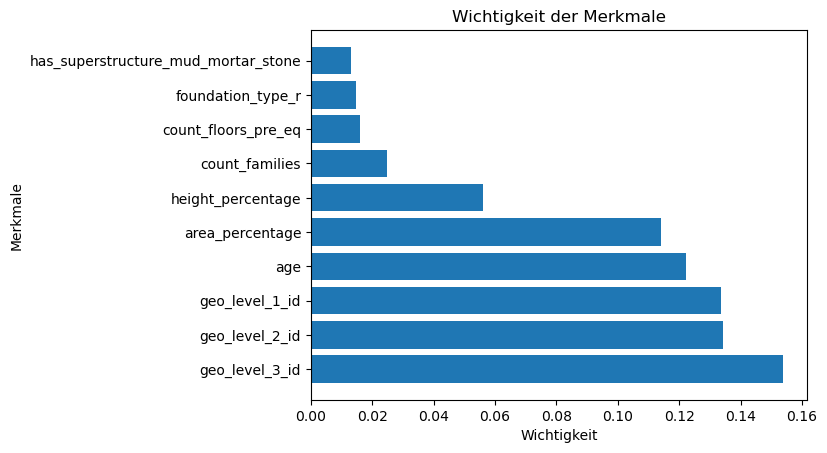

In [32]:
importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)

plt.barh(importance['feature'][:10], importance['importance'][:10])

plt.title('Wichtigkeit der Merkmale')
plt.xlabel('Wichtigkeit')
plt.ylabel('Merkmale')
plt.show()


### 4.1.4 Lernkurve (Änderung der F1-Score im Laufe der Zeit)
F1-Score im Laufe der Zeit: Wenn man Modell im Laufe der Zeit auf unterschiedlichen Datensätzen trainiert, kann man den F1-Score nach jedem Training plotten. 

Hier ist eine Lernkurve, die zeigt, wie der F1-Score des Modells sich verändert, wenn wir die Größe des Trainingsdatensatzes ändern. Dies kann uns helfen zu verstehen, ob unser Modell von mehr Daten profitieren würde oder ob es bereits genügend Daten zum Lernen hat. Dazu haben wir die learning_curve Funktion von sklearn verwendet.

In dieser Grafik repräsentiert die x-Achse die Größe des Trainingssatzes und die y-Achse repräsentiert den F1-Score. Die blaue Linie zeigt den F1-Score auf den Trainingssätzen. Dass die Kurve konvergiert, deutet dies darauf hin, dass das Modell von zusätzlichen Trainingsdaten nicht mehr profitiert. Wenn die Linie nicht konvergieren würde, könnte das Modell von mehr Trainingsdaten profitieren.

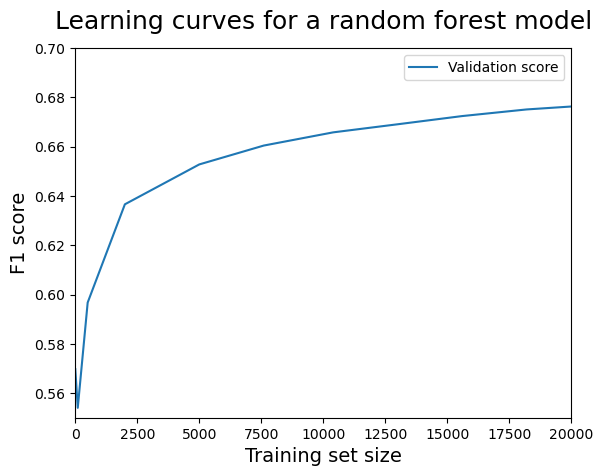

In [33]:
from sklearn.model_selection import learning_curve

# Definieren der Trainingssatzgrößen
train_sizes = [1, 100, 500, 2000, 5000, 7600, 10400, 13000, 15600, 18200, 20800, 26066]

# Erhalten der Trainingssatzgrößen und der Trainingsscores
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = RandomForestClassifier(random_state=42),
    X = X_train,
    y = y_train, 
    train_sizes = train_sizes, 
    cv = 5,
    scoring = 'f1_micro'
)

# Berechnung der Durchschnittswerte und Standardabweichungen für die Trainingsscores
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

# Begrenzung der Achsen
plt.ylim(0.55, 0.7)
plt.xlim(0, 20000)

# ploten der Lernkurven
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation score')

# Erstellen der Achsentitel und der Legende
plt.ylabel('F1 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a random forest model', fontsize = 18, y = 1.03)
plt.legend()

# Anzeigen des Plots
plt.show()

# 5. Vorhersagen für Testdaten
Wir wollen unser Modell verwenden, um Vorhersagen für die Testdaten zu machen. Hier importieren wir `test_values.csv`, unsere Testdaten und machen Vorhersagen anhand vom oben trainierten Modell.

In [34]:
# Laden der Testdaten
test_values = pd.read_csv('test_values.csv')

# One-Hot-Encoding für kategoriale Variablen in den Testdaten
one_hot_encoded_test = one_hot_encoder.transform(test_values[categorical_cols])

# Erzeugen eines DataFrames für die kodierten Testdaten
X_test_encoded = pd.DataFrame(one_hot_encoded_test, columns=encoded_cols)
X_test = pd.concat([test_values.drop(columns=categorical_cols), X_test_encoded], axis=1)

# Entfernen der 'building_id' Spalte aus den Testdaten
X_test = X_test.drop(columns='building_id')

# Vorhersagen machen
test_predictions = model.predict(X_test)

# Erzeugen eines DataFrames für die Vorhersagen
predictions_df = pd.DataFrame({'building_id': test_values['building_id'], 'damage_grade': test_predictions})

# Anzeigen der Vorhersagen
print(predictions_df)

       building_id  damage_grade
0           300051             3
1            99355             2
2           890251             2
3           745817             1
4           421793             3
...            ...           ...
86863       310028             2
86864       663567             2
86865      1049160             2
86866       442785             2
86867       501372             2

[86868 rows x 2 columns]


## 5.1 Zusammenfassung und Ergebnis
Das obige Ergebnis ist ein DataFrame, der die Vorhersagen des Schadensgrades für jedes Gebäude in den Testdaten enthält. Jede Zeile in dem DataFrame repräsentiert ein Gebäude. Die `building_id` Spalte gibt die ID des Gebäudes an, und die `damage_grade` Spalte gibt den vom Modell vorhergesagten Schadensgrad an.

Zum Beispiel, für das Gebäude mit der ID 300051 hat das Modell vorhergesagt, dass es einen Schadensgrad von 3 hat, was fast vollständige Zerstörung bedeutet. Für das Gebäude mit der ID 99355 hat das Modell vorhergesagt, dass es einen Schadensgrad von 2 hat, was eine mittlere Menge an Schaden bedeutet.